```{index} single: Pyomo; block
```
```{index} single: conic programming; second order cones
```
```{index} single: Pyomo; kernel library
```
```{index} single: solver; mosek
```
```{index} single: application; inventory management
```

# Economic Order Quantity

This notebooks demonstrates the reformulation of hyperbolic constraints as SOCP with implementation with `pyomo.kernel.conic.quadratic` and also the direct modeling of the hyperbolic constraint with `pyomo.kernel.conic.rotated_quadratic`. The example is familiar to any MBA/business student, and has a significant range of applications including warehouse operations.

## Usage notes

* The notebook requires a solver that can handle a conic constraint. Pyomo provides a direct interface to the commercial solvers Gurobi and Mosek that include conic solvers. Other nonlinear solvers may solve this problems using more general techniques that are not specific to conic constraints. 
* For personal installations of Mosek or Gurobi (free licenses available for academic use), use `mosek_direct` or `gurobi_direct`.
* If you do not have access to the Gurobi or Mosek, you can use the `ipopt` solver. Note, however, that `ipopt` is a general purpose interior point solver, and does not have algorithms specific to conic problems.

In [1]:
# install Pyomo and solvers
import sys

if "google.colab" in sys.modules:
    !pip install -q idaes-pse >/dev/null 2>/dev/null
    !idaes -q get-extensions
    import idaes
    conic_solver = "/root/.idaes/bin/ipopt"

else:
    conic_solver = "mosek_direct"

## The EOQ model

### Classical formulation for a single item

The economic order quantity (EOQ) is a classical problem in inventory management attributed to Ford Harris (1915). The problem is to find the order quantity that minimizes the cost of maintaining a specific item in inventory 

The cost for maintaining an item in inventory given an order size $x$ is given by

$$f(x) = \frac{h x}{2} + \frac{c d}{x}$$

where $h$ is the annual cost of holding an item including financing charges, $c$ is the fixed cost of placing and receiving an order, and $d$ is the annual demand. The factor $\frac{1}{2}$ is a result of demand depletes the inventory at a constant rate over the year. The economic order quantity is the value of $x$ that minimizes $f(x)$

$$
\begin{align*}
EOQ = \arg\min_x\ & f(x) = \frac{h x}{2} + \frac{c d}{x} \\
\qquad \text{s.t.}\quad & x > 0 \\
\end{align*}
$$

Given the rather simple domain, we can derive analytically the solution for the EOQ problem by setting the derivative of $f(x)$ equal to zero and solving the resulting equation, obtaining

$$
\begin{align*}
EOQ = x^{opt} & = \sqrt{\frac{2 c d}{h}} \\
f^{opt} & = \sqrt{2 c d h} 
\end{align*}
$$

The following chart illustrates the nature of the problem and its analytical solution.

Optimal order size = 3651.5 items with cost 2738.61


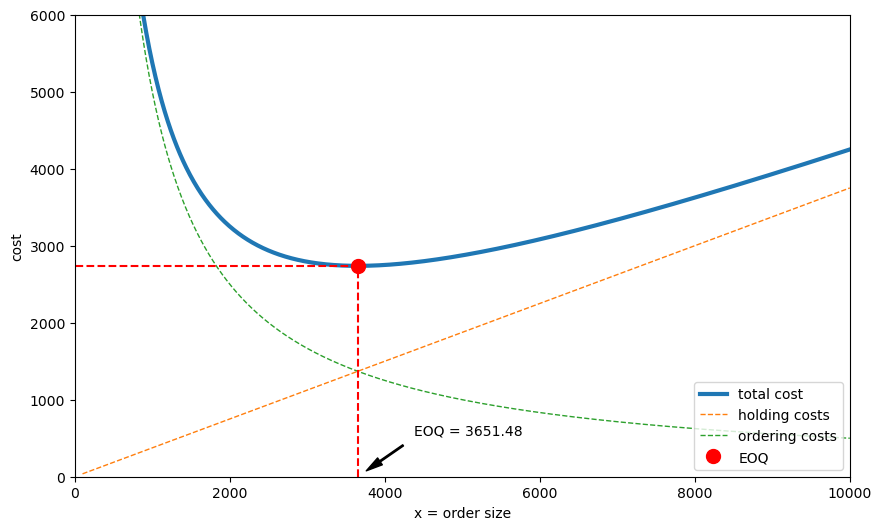

In [2]:
import matplotlib.pyplot as plt
import numpy as np

h = 0.75      # cost of holding one item for one year 
c = 500.0     # cost of processing one order
d = 10000.0   # annual demand

eoq = np.sqrt(2*c*d/h)
fopt = np.sqrt(2*c*d*h)
print(f"Optimal order size = {eoq:0.1f} items with cost {fopt:0.2f}")

x = np.linspace(100, 10000, 1000)
f = h*x/2 + c*d/x

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, f, lw=3, label="total cost")
ax.plot(x, h*x/2, '--', lw=1, label="holding costs")
ax.plot(x,  c*d/x, '--', lw=1, label="ordering costs")
ax.set_xlabel("x = order size")
ax.set_ylabel("cost")
ax.plot(eoq, fopt, 'ro', ms=10, label="EOQ")
ax.legend(loc='lower right')
ax.annotate(f"EOQ = {eoq:0.2f}", xy=(eoq, 0), xytext=(1.2*eoq, 0.2*fopt),
           arrowprops=dict(facecolor="black", shrink=0.15, width=1, headwidth=6))
ax.plot([eoq, eoq, 0], [0, fopt, fopt], 'r--')
ax.set_xlim(0, 10000)
ax.set_ylim(0, 6000);

### Reformulating EOQ as a linear objective with hyperbolic constraint

However, if the problem involved multiple products, an analytical solution would no longer be easily available. For this reason, we need to be able to solve the problem numerically, let us see how.

It can be easily checked that the objective $f(x)$ is a convex function and therefore, the problem can be solved using any convex optimization solver. It is, however, a special type of convex problem which we shall show in the following reformulation.

The optimization objective is linearized with the use of a second decision variable $y = 1/x$. The optimization problem is now a linear objective in two decision variables with a hyperbolic constraint $xy \geq 1$.

$$
\begin{align*}
\min_{x, y}\ & f(x, y) = \frac{h x}{2} + c d y \\
\quad \text{s.t.}\quad 
& x y  \geq 1 \\
& x, y > 0 \\
\end{align*}
$$

This constraint and the linear contours of the objective function are shown in the following diagrams. The solution of optimization problem occurs at a point where the constraint is tangent to  contours of the objective function.


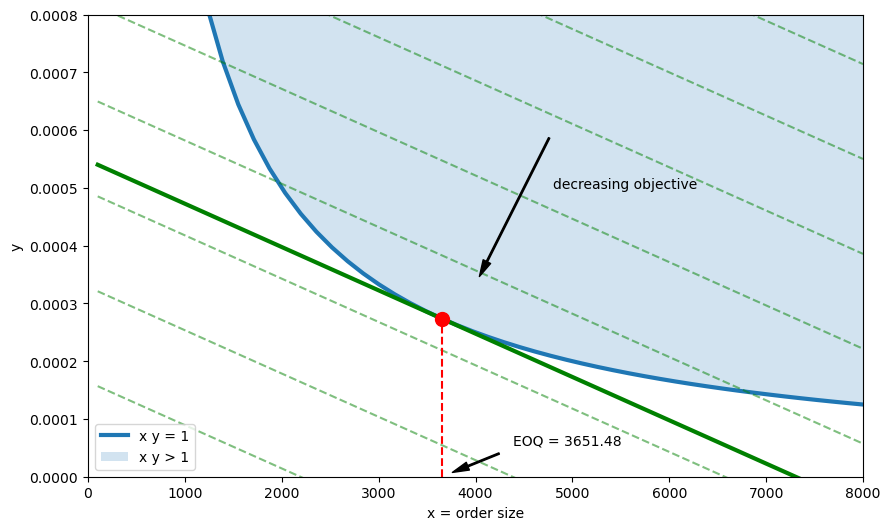

In [3]:
import matplotlib.pyplot as plt
import numpy as np

h = 0.75      # cost of holding one item for one year 
c = 500.0     # cost of processing one order
d = 10000.0   # annual demand

x = np.linspace(100, 8000)
y = (fopt - h*x/2)/(c*d)

eoq = np.sqrt(2*c*d/h)
fopt = np.sqrt(2*c*d*h)
yopt = (fopt - h*eoq/2)/(c*d)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, 1/x, lw=3, label="x y = 1")
ax.plot(x, (fopt - h*x/2)/(c*d), 'g', lw=3)
for f in fopt*np.linspace(0, 3, 11):
    ax.plot(x, (f - h*x/2)/(c*d), 'g--', alpha=0.5)
ax.plot(eoq, yopt, 'ro', ms=10)
ax.annotate(f"EOQ = {eoq:0.2f}", xy=(eoq, 0), xytext=(1.2*eoq, 0.2*yopt),
           arrowprops=dict(facecolor="black", shrink=0.15, width=1, headwidth=6))

ax.annotate("", xytext=(4800, 0.0006), xy=(4000, 1/3000),
           arrowprops=dict(facecolor="black", shrink=0.05, width=1, headwidth=6))
ax.text(4800, .0005, "decreasing objective")
ax.fill_between(x, 1/x, 0.0008, alpha=0.2, label="x y > 1")
ax.plot([eoq, eoq], [0, yopt], 'r--')

ax.set_xlim(0, 8000)
ax.set_ylim(0, .0008)
ax.set_xlabel('x = order size')
ax.set_ylabel('y')
ax.legend();


## Reformulating the EOQ model with a linear objective and a second order cone constraint

In elementary geometry, a hyperbola can be constructed from the intersection of a linear plane with cone. For this application, the hyperbola described by the constraint $x y \geq 1$ invites the question of whether there is reformulation of EOQ that includes a cone constraint.

A Lorenz cone is defined by

$$
\begin{align*}
C & = \{ (z, t)\in\mathbb{R}^3 \ | \ \| z \|_2 \leq t \}
\end{align*}
$$

where the components of are given by $z = \begin{bmatrix} u \\ v \end{bmatrix}$. The intersection of a plane aligned with the $t$ axis exactly describes a hyperbola. As described by Lobo, et al. (1998), the correspondence is given by

$$w^2 \leq x y,\ x, y\geq 0,\ \iff \left \|\begin{bmatrix} 2w \\ x-y \end{bmatrix} \right \|_2 \leq x + y $$

where the axis in the $w, x, y$ coordinates is tilted, displaced, and stretched compared to the coordinates shown in the diagram. The exact correspondence to the diagram is given by

$$\begin{align*}
u & \sim 2 w \\
v & \sim x - y \\
t & \sim x + y
\end{align*}$$

The Python code belows draws a hyperbola precisely as the intersection of a plane with Lorenz cone.

Let us know rewrite the nonlinear constraint of the EOQ problem. Using the same geomtric idea as above and leveraging the nonnegativity of both variables, the constraint $xy \geq 1$ can be reformulated using the following trick:

$$
    xy \geq 1 \quad \Longleftrightarrow \quad 4xy \geq 4 \quad \Longleftrightarrow \quad (x + y)^2 - (x - y)^2 \geq 4  \quad \Longleftrightarrow \quad \left \|\begin{bmatrix} 2 \\ x-y \end{bmatrix} \right \|_2 \leq x + y,
$$

where we rely on the fact that $x + y \geq 0$. The final constraint is known as a second-order conic optimization constraint (SOCP constraint). The result is a reformulation of the EOQ problem as a second order conic program (SOCP).

$$\begin{align*}
\min_{x, y}\quad & f(x, y) = \frac{h x}{2} + c d y \\
\text{s.t.}\quad & \left \|\begin{bmatrix} 2 \\ x-y \end{bmatrix} \right \|_2 \leq x + y
\end{align*}
$$

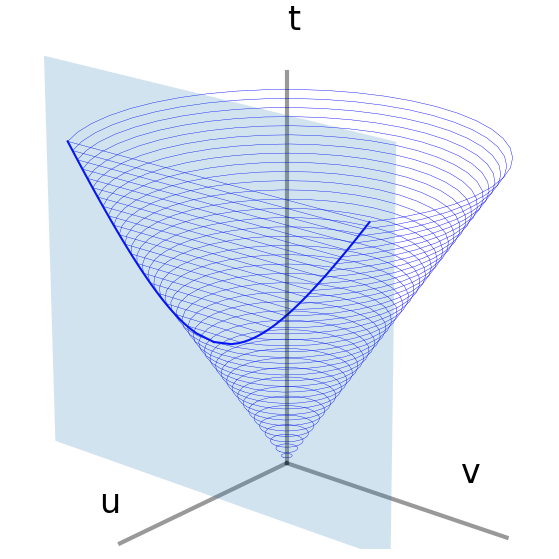

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Rectangle

t_max = 4
w = 2
n = 40

fig = plt.figure(figsize=(9, 7))
ax = plt.axes(projection='3d')

for t in np.linspace(0, t_max, n+1):
    if t < w:
        a = np.linspace(0, 2*np.pi, 30)
        u = t*np.cos(a)
        v = t*np.sin(a)
        ax.plot3D(u, v, t, 'b', lw=0.3)
    else:
        b = np.arccos(w/t)
        a = np.linspace(b, 2*np.pi-b, 30)
        u = t*np.cos(a)
        v = t*np.sin(a)
        ax.plot3D(u, v, t, 'b', lw=0.3) 
        ax.plot3D([2, 2], [t*np.sin(b), -t*np.sin(b)], [t, t], 'b', lw=0.3)        

t = np.linspace(w, t_max)
v = t*np.sin(np.arccos(w/t))
u = w*np.array([1]*len(t))
ax.plot3D(u, v, t, 'b')
ax.plot3D(u, -v, t, 'b')

ax.plot3D([0, t_max + 0.5], [0, 0], [0, 0], 'k', lw=3, alpha=0.4)
ax.plot3D([0, 0], [0, t_max + 1], [0, 0], 'k', lw=3, alpha=0.4)
ax.plot3D([0, 0], [0, 0], [0, t_max + 1], 'k', lw=3, alpha=0.4)

ax.text3D(t_max + 1, 0, 0.5, 'u', fontsize=24)
ax.text3D(0, t_max , 0.5, 'v', fontsize=24)
ax.text3D(0, 0, t_max + 1.5, 't', fontsize=24)

ax.view_init(elev=20, azim=40)

r = Rectangle((-t_max, 0), 2*t_max, t_max + 1, alpha=0.2)
ax.add_patch(r)
art3d.pathpatch_2d_to_3d(r, z=w, zdir="x")

ax.grid(False)
ax.axis('off')

ax.set_xlabel('u')
ax.set_ylabel('v')

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_zlim(1, 4)
plt.show()

## Pyomo modeling with `conic.quadratic`

The SOCP formation given above needs to be reformulated one more time to use with the Pyomo `conic.quadratic` constraint. The first step is to introduce rotated coordinates $t = x+ y$ and $v = x - y$, and introduce a new variable with fixed value $u = 2$, to fit the Pyomo model for quadratic constraints, 

$$\begin{align*}
\min_{x, y}\quad & f(x, y) = \frac{h x}{2} + c d y \\
\text{s.t.} \quad
& t  = x + y \\
& u = 2 \\
& v = x - y \\
& u^2 + v^2 \leq t^2 \\
& x, y, t, u, v \geq 0
\end{align*}$$

This version of the model with variables $t, u, v, x, y$ could be implemented directly in Pyomo with `conic.quadratic`. However, the model can be further reduced to yield a simpler version of the model.

$$\begin{align*}
\min_{t, u, v}\quad &  f(u, v) = \frac{1}{4}\left[(h + 2 cd)\,t + (h - 2 cd)\, v\right] \\
\text{s.t.} \quad
& u = 2 \\
& u^2 + v^2 \leq t^2 \\
& t, u, v \geq 0
\end{align*}$$

The EOQ model is now ready to implement with Pyomo and specifically using the [Pyomo kernel library](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/index.html#). The Pyomo kernel library provides an experimental modeling interface for advanced application development with Pyomo. In particular, the kernel library provides direct support for conic constraints with the Mosek or Gurobi commercial solvers (note that academic licenses are available at no cost, a demo version of Gurobi is available on Google Colab). 

The Pyomo interface to conic solvers includes six forms for conic constraints. The `conic.quadratic` constraint is expressed in the form

$$\sum_{i} x_i^2 \leq r^2, \ r \geq 0$$

where the $x_i$ and $r$ terms are pyomo.kernel variables. Note the slighly different syntax of the Pyomo kernel commands.

In [5]:
import pyomo.kernel as pmo

h = 0.75      # cost of holding one item for one year 
c = 500.0     # cost of processing one order
d = 10000.0   # annual demand

m = pmo.block()

# define variables for conic constraints
m.u = pmo.variable(lb=0)
m.v = pmo.variable(lb=0)
m.t = pmo.variable(lb=0)

# relationships for conic constraints to decision variables
m.u_eq = pmo.constraint(m.u == 2)
m.q = pmo.conic.quadratic(m.t, [m.u, m.v])

# linear objective
m.eoq = pmo.objective(((h + 2*c*d)*m.t + (h - 2*c*d)*m.v)/4)

# solve
solver = pmo.SolverFactory(conic_solver)
solver.solve(m)

# solution
print(f"\nEOQ = {(m.t() + m.v())/2:0.2f}")


EOQ = 3653.04


## The `.as_domain()` method simplifie the Pyomo model

`pyomo.kernel` provides additional support for conic solvers with the `.as_domain()` method that be applied to the conic solver interfaces. Adding `.as_domain` allows use of constants, linear expressions, or `None` in place of pyomo variables. For this application, this means `u` does not have to be included as a pyomo variable and constrained to a fixed value. The required value can simply be inserted directly into constraint specification as demonstrated below.

In [6]:
import pyomo.kernel as pmo

h = 0.75      # cost of holding one item for one year 
c = 500.0     # cost of processing one order
d = 10000.0   # annual demand

m = pmo.block()

# define variables for conic constraints
m.v = pmo.variable(lb=0)
m.t = pmo.variable(lb=0)

# relationships for conic constraints to decision variables
m.q = pmo.conic.quadratic.as_domain(m.t, [2, m.v])

# linear objective
m.eoq = pmo.objective(((h + 2*c*d)*m.t + (h - 2*c*d)*m.v)/4)

# solve
solver = pmo.SolverFactory(conic_solver)
solver.solve(m)

# solution
print(f"\nEOQ = {(m.t() + m.v())/2:0.2f}")


EOQ = 3653.04


## Pyomo Modeling with `conic.rotated_quadratic`

The need to rotate the natural coordinates of the EOQ problem to fit the programming interface to `conic.quadratic` is not a big stumbling block, but does raise the question of whether there is a more natural way to express hyperbolic or cone constraints in Pyomo. 

`pyomo.kernel.conic.rotated_quadratic` expresses constraints in the form

$$\sum_{i} x_i^2 \leq 2 r_1 r_2 \quad r_1, r_2 \geq 0$$

This enables a direct a expression of the hyperbolic constraint $x y \geq 1$ by introducing an auxiliary variable $z$ with fixed value $z^2 = 2$ such that 

$$xy \geq 1 \iff z^2 \leq 2 x y \quad\text{where }z^2 = 2$$

The model to be implemented in Pyomo is now

$$
\begin{align*}
\min_{x, y}\quad & f(x, y) = \frac{h x}{2} + c d y \\
\text{s.t.} \quad 
& z^2 \leq 2 x\,y  \\
& z = \sqrt{2} \\
& x, y > 0 \\
\end{align*}
$$

which is demonstrated below. Note the improvement in accuracy of this calculation compared to the previous solutions. Also note the use of `.as_domain()` eliminates the need to specify a variable $z$.

In [7]:
import pyomo.kernel as pmo

h = 0.75      # cost of holding one time for one year 
c = 500.0     # cost of processing one order
d = 10000.0   # annual demand

m = pmo.block()

# define variables for conic constraints
m.x = pmo.variable(lb=0)
m.y = pmo.variable(lb=0)

# conic constraint
m.q = pmo.conic.rotated_quadratic.as_domain(m.x, m.y, [np.sqrt(2)])

# linear objective
m.eoq = pmo.objective(h*m.x/2 + c*d*m.y)

# solve
solver = pmo.SolverFactory(conic_solver)
solver.solve(m)

# solution
print(f"\nEOQ = {m.x():0.2f}")


EOQ = 3651.48


## Extending the EOQ model multiple items with a shared resource

Solving for the EOQ for a single item using SOCP programming is using a sledgehammer to swat a fly. However, the problem becomes more interesting for determining economic order quantities when the inventories for multiple items compete for a shared resource in a common warehouse. The shared resource could he financing available to hold inventory, space in a warehouse, or specialized facilities to hold a perishable 

$$
\begin{align*}
\min \quad & \sum_{i=1}^n \frac{h x_i}{2} + \frac{c_i d_i}{x_i} \\
\text{s.t.} \quad
& \sum_{i=1}^n b_i x_i  \leq b_0 \\
& 0 < lb_i \leq x_i \leq ub_i & \forall i\in 1, \dots, n \\
\end{align*}
$$

where $h_i$ is the annual holding cost for one unit of item $i$, $c_i$ is the cost to place an order and receive delivery for item $i$, and $d_i$ is the annual demand. The additional constraint models an allocation of $b_i$ of the shared resource, and $b_0$ is the total resource available.

Following the reformulation of the single item model, a variable $y_i 
\geq 0$, $i=1, \dots, n$ is introduced to linearize the objective

$$
\begin{align*}
\min \quad & \sum_{i=1}^n \frac{h x_i}{2} + c_i d_i y_i \\
\text{s.t.} \quad 
& \sum_{i=1}^n b_i x_i  \leq b_0 \\
& x_i y_i \geq 1 & \forall i\in 1, \dots, n \\
& 0 < lb_i \leq x_i \leq ub_i & \forall i\in 1, \dots, n \\
& y_i \geq 0 & \forall i\in 1, \dots, n \\
\end{align*}
$$

Following the discussion above regarding rotated quadratic constraints, auxiliary variables $z_i$ for $i=1, \dots, n$ is introduced


$$
\begin{align*}
\min \quad & \sum_{i=1}^n \frac{h x_i}{2} + c_i d_i y_i \\
\text{s.t.} \quad 
& \sum_{i=1}^n b_i x_i  \leq b_0 \\
& z_i^2 \leq x_i y_i & \forall i\in 1, \dots, n \\
& z_1^2 = 2 & \forall i\in 1, \dots, n \\
& 0 < lb_i \leq x_i \leq ub_i & \forall i\in 1, \dots, n \\
& y_i \geq 0 & \forall i\in 1, \dots, n \\
\end{align*}
$$

The following Pyomo model is a direct implementation of the multi-time EOQ formulation and applied to a hypothetical car parts store that maintains an inventory of tires.

In [8]:
import pandas as pd

df = pd.DataFrame({
    "all weather":   {"h": 1.0, "c": 200, "d": 1300, "b": 3},
    "truck":         {"h": 2.8, "c": 250, "d":  700, "b": 8},
    "heavy duty":    {"h": 1.2, "c": 200, "d":  500, "b": 5},
    "low cost":      {"h": 0.8, "c": 180, "d": 2000, "b": 3},
}).T

display(df)

,h,c,d,b
all weather,1.0,200.0,1300.0,3.0
truck,2.8,250.0,700.0,8.0
heavy duty,1.2,200.0,500.0,5.0
low cost,0.8,180.0,2000.0,3.0


,h,c,d,b
all weather,1.0,200.0,1300.0,3.0
truck,2.8,250.0,700.0,8.0
heavy duty,1.2,200.0,500.0,5.0
low cost,0.8,180.0,2000.0,3.0


,EOQ,Space Req'd
product,,
all weather,306.2,918.7
truck,153.2,1225.3
heavy duty,151.0,754.9
low cost,367.0,1101.1


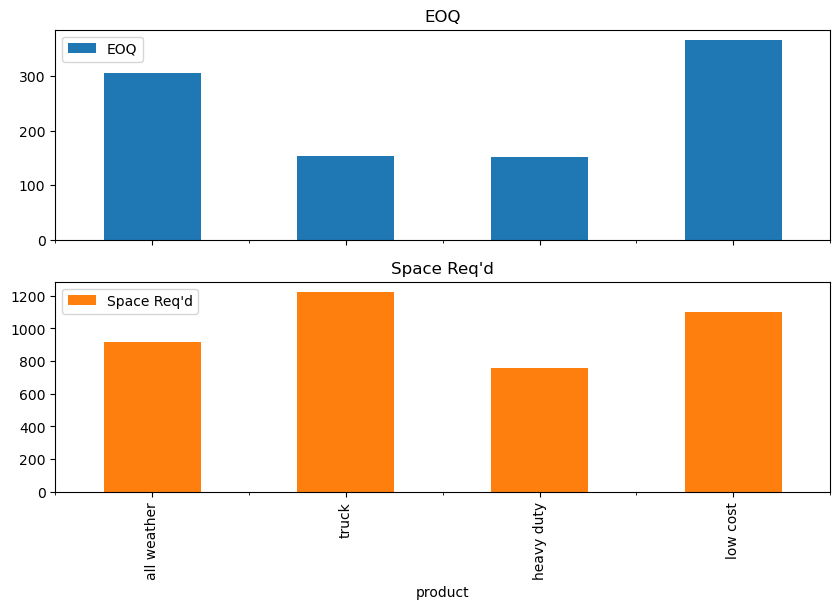

In [9]:
import pyomo.kernel as pmo
import numpy as np

display(df)

def eoq(df, b):

    m = pmo.block()
    
    m.b = pmo.parameter(b)
    
    m.I = df.index

    # variable dictionaries
    m.x = pmo.variable_dict()
    for i in m.I:
        m.x[i] = pmo.variable(lb=0)

    m.y = pmo.variable_dict()
    for i in m.I:
        m.y[i] = pmo.variable(lb=0)

    # use a block_dict because .as_domain returns a block
    m.q = pmo.block_dict()
    for i in m.I:
        m.q[i] = pmo.conic.rotated_quadratic.as_domain(m.x[i], m.y[i], [np.sqrt(2)])
        
    m.b_cap = pmo.constraint(sum(df.loc[i, "b"]*m.x[i] for i in m.I) <= m.b)
        
   # objective
    m.eoq = pmo.objective(sum(df.loc[i, "h"]*m.x[i]/2 + df.loc[i, "c"]*df.loc[i, "d"]*m.y[i] for i in m.I))

    # solve with Mosek
    solver = pmo.SolverFactory(conic_solver)
    solver.solve(m)
    
    return m

def eoq_display_results(df, m):

    results = pd.DataFrame([
        [i, m.x[i](), m.x[i]()*df.loc[i, "b"]] 
        for i in m.I],
        columns = ["product", "EOQ", "Space Req'd"]).round(1)
    results.set_index("product", inplace=True)

    display(results)
    results.plot(y = ["EOQ", "Space Req'd"], kind="bar", subplots=True, layout=(2, 1), figsize=(10, 6))
    
m = eoq(df, 4000)
eoq_display_results(df, m)

## Testing the model on larger problems

The following cell creates a random EOQ problem of size $n$ that can be used to test the model formulation and solver.

,EOQ,Space Req'd
product,,
product 000,50.0,1923.8
product 001,35.6,1369.6
product 002,112.0,4308.4
product 003,94.6,3638.5
product 004,98.2,3776.0
product 005,55.9,2151.3
product 006,129.0,4959.7
product 007,81.1,3118.8
product 008,63.9,2457.1


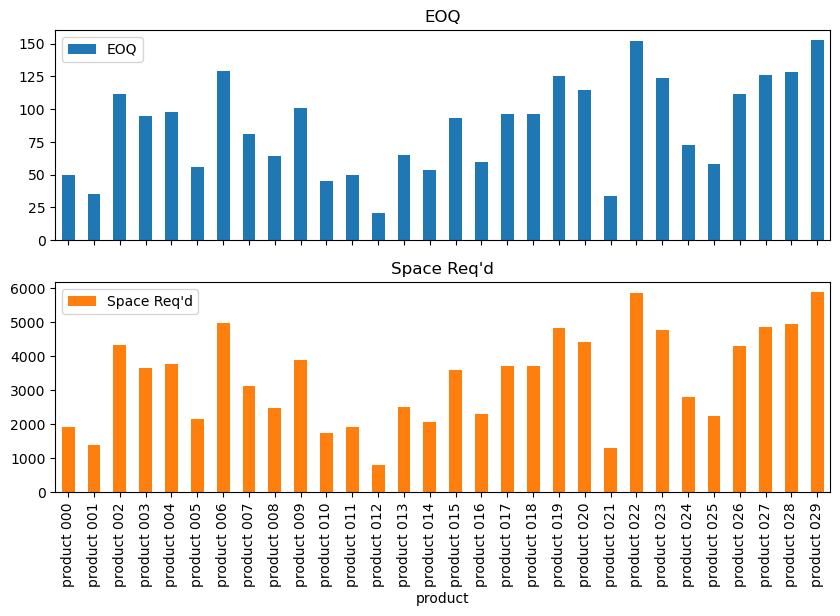

In [10]:
n = 30

df_large = pd.DataFrame()
df_large["h"] = np.random.uniform(0.5, 2.0, n)
df_large["c"] = np.random.randint(300, 500, n)
df_large["d"] = np.random.randint(100, 5000, n)
df_large["b"] = np.random.uniform(10, 50)
df_large.set_index(pd.Series(f"product {i:03d}" for i in range(n)), inplace=True)

df_large

m = eoq(df_large, 100000)
eoq_display_results(df_large, m)

## Bibliographic notes

The original formulation and solution of the economic order quantity problem is attributed to Ford Harris, but in a curious twist has been [cited incorrectly since 1931](https://pubsonline.informs.org/doi/abs/10.1287/mnsc.35.7.898). The correct citation is:

>Harris, F. W. (1915). Operations and Cost (Factory Management Series). A. W. Shaw Company, Chap IV, pp.48-52. Chicago. 

Harris later developed an extensive consulting business and the concept has become embedded in business practice for over 100 years. Harris's single item model was later extended to multiple items sharing a resource constraint. There may be earlier citations, but this model is generally attributed to Ziegler (1982):

> Ziegler, H. (1982). Solving certain singly constrained convex optimization problems in production planning. Operations Research Letters, 1(6), 246-252. https://www.sciencedirect.com/science/article/abs/pii/016763778290030X

> Bretthauer, K. M., & Shetty, B. (1995). The nonlinear resource allocation problem. Operations research, 43(4), 670-683. https://www.jstor.org/stable/171693?seq=1

Reformulation of the multi-item EOQ model as a conic program is attributed to Kuo and Mittleman (2004) using techniques described by Lobo, et al. (1998):

> Kuo, Y. J., & Mittelmann, H. D. (2004). Interior point methods for second-order cone programming and OR applications. Computational Optimization and Applications, 28(3), 255-285. https://link.springer.com/content/pdf/10.1023/B:COAP.0000033964.95511.23.pdf

> Lobo, M. S., Vandenberghe, L., Boyd, S., & Lebret, H. (1998). Applications of second-order cone programming. Linear algebra and its applications, 284(1-3), 193-228. https://web.stanford.edu/~boyd/papers/pdf/socp.pdf

The multi-item model has been used didactically many times since 2004. These are representative examples 

> Letchford, A. N., & Parkes, A. J. (2018). A guide to conic optimisation and its applications. RAIRO-Operations Research, 52(4-5), 1087-1106. http://www.cs.nott.ac.uk/~pszajp/pubs/conic-guide.pdf

> El Ghaoui, Laurent (2018). Lecture notes on Optimization Models. https://inst.eecs.berkeley.edu/~ee127/fa19/Lectures/12_socp.pdf

> Mosek Modeling Cookbook, section 3.3.5.  https://docs.mosek.com/modeling-cookbook/cqo.html.


## Appendix: Formulation with SOCP constraints

Pyomo's facility for directly handling hyperbolic constraints bypasses the need to formulate SOCP constraints for the multi-item model. For completeness, however, that development is included here.

As a short cut to reformulating the model with conic constraints, note that a "completion of square" gives the needed substitutions

$$
\begin{align*}
(x_i + y_i)^2  = x_i^2 + 2 x_i y_i + y_i^2 \\
- (x_i - y_i)^2  = - x_i^2 + 2 x_i y_i - y_i^2 \\
\rule{6cm}{0.4pt} \\
\implies (x_i + y_i)^2 - (x_i - y_i)^2  = 4 x_i y_i \\
\end{align*}
$$

The multi-item EOQ model is now written with conic constraints

$$
\begin{align*}
\min \quad & \sum_{i=1}^n \frac{h x_i}{2} + c_i d_i y_i \\
\text{s.t.} \quad 
& \sum_{i=1}^n b_i x_i  \leq b_0 \\
& 4 + (x_i - y_i)^2 \leq (x_i + y_i)^2 & \forall i\in 1, \dots, n \\
& 0 < lb_i \leq x_i \leq ub_i & \forall i\in 1, \dots, n \\
& y_i \geq 0 & \forall i\in 1, \dots, n \\
\end{align*}
$$

Variables $t_i$, $u_i$, and $v_i$ are introduced t complete the reformulation for implementation with Pyomo/Mosek.

$$
\begin{align*}
\min \quad & \sum_{i=1}^n \frac{h x_i}{2} + c_i d_i y_i \\
\text{s.t.} \quad 
& \sum_{i=1}^n b_i x_i \leq b_0 \\
& t_i = x_i + y_i & \forall i\in 1, \dots, n \\
& u_i = 2 & \forall i \in 1, \dots, n \\
& v_i = x_i - y_i & \forall i\in 1, \dots, n \\
& u_i^2 + v_i^2 \leq t_i^2 & \forall i\in 1, \dots, n \\
& 0 < lb_i \leq x_i \leq ub_i & \forall i\in 1, \dots, n \\
& t_i, u_i, v_i, y_i \geq 0 & \forall i\in 1, \dots, n \\
\end{align*}
$$